In [1]:
# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
import pickle
from fdd import OperationMode
from fdd import FDD

import scipy.io
from scipy import linalg
from sklearn.datasets import make_blobs
from sklearn.mixture import PGMM
from scipy.stats import randint as sp_randint

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from matplotlib.colors import LogNorm
from sklearn.grid_search import GridSearchCV
from time import time

In [2]:
# Load Tennessee Eastman Process Data
original_data = pickle.load( open( "data/tep_data_sequence.dat", "rb" ) )
original_normal_data = original_data["Normal"]
original_normal_data.shape

(721, 22)

---------------
Applying data Windows of type: Normal
There is no model registered, creating a normal one.
---------------
---------------
Applying data Windows of type: Fault14_1
Out of normal operation condition detected.
Unrecognized behaviour, training a new model.
516
---------------
---------------
Applying data Windows of type: Fault13_1
Out of normal operation condition detected.
Unrecognized behaviour, training a new model.
635
---------------
---------------
Applying data Windows of type: Fault2_1
Out of normal operation condition detected.
Unrecognized behaviour, training a new model.
326
---------------
---------------
Applying data Windows of type: Fault11_1
Out of normal operation condition detected.
Unrecognized behaviour, training a new model.
244
---------------
---------------
Applying data Windows of type: Fault13_2
Out of normal operation condition detected.
Operation mode classified as: Fault13_1
---------------
---------------
Applying data Windows of type: Fault2

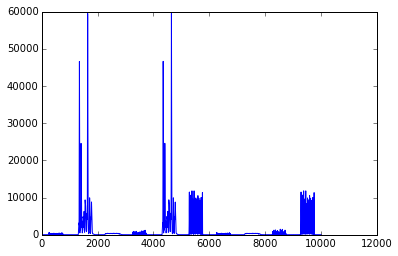

In [3]:
sequence = ["Normal",
            "Fault14_1", 
            "Fault13_1", 
            "Fault2_1", 
            "Fault11_1", 
            "Fault13_2", 
            "Fault20_1", 
            "Fault14_2", 
            "Fault2_1", 
            "Fault11_2", 
            "Fault20_1"]
fdd = FDD(name='TEPFDD',
          training_type='spark',
          n_components=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]),
          n_pc=np.array([2, 3, 5, 7, 11, 13, 15, 17]),
          covar_types=np.array([1, 2, 3, 4, 5, 6, 7, 8]),
          n_jobs=64)
complete_stats = np.empty(0)
for key in sequence:
    print '---------------'
    print 'Applying data Windows of type: {}'.format(key)
    x_windows = original_data[key]
    normal_stats, normal_thr, best_status, best_thr, best_id, is_new = fdd.fdd(x_windows)
    if is_new:
        fdd.set_op_name(best_id, key)
        fdd.set_op_kind(best_id, key[0])
        fdd.set_op_status(best_id, 'OK')
    complete_stats = np.concatenate((complete_stats, normal_stats), axis=0)
    print '---------------'
    
plt.plot(complete_stats)

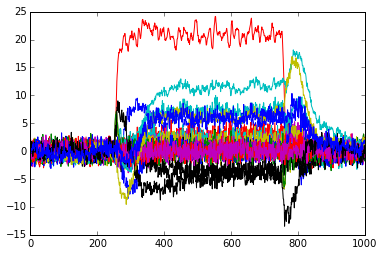

In [4]:
x1 = original_data["Fault2_1"]
plt.plot(x1)

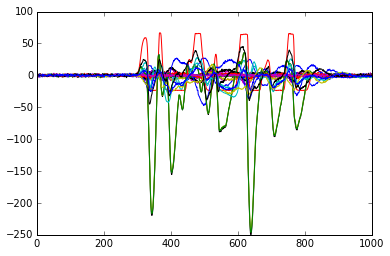

In [5]:
x2 = original_data["Fault13_2"]
plt.plot(x2)